# Simple demo of Poisson semi-NMF on synthetic data

The model is described here: https://www.overleaf.com/project/649e4d41313d17d01bde7cfb


## Notes


In [1]:
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt

from jax.nn import softplus
from seminmf import seminmf_v5 as seminmf
from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions

## Make synthetic 2D dataset for testing

In [22]:
key = jr.PRNGKey(4)
num_mice = 200
height, width = 100, 100
num_factors = 3
emission_noise_scale = 1.0
loading_scale = 0.1 * height * width 
mean_func = softplus

# Sample parameters and data
k1, k2, k3, k4 = jr.split(key, 4)

# Row and column effects
true_row_effects = 10 * jnp.ones(num_mice)
true_column_effects = jnp.zeros(height * width)

# Factors
xx, yy = jnp.meshgrid(jnp.arange(width), jnp.arange(height))
true_factors = jnp.zeros((num_factors, height, width))
true_factors = true_factors.at[0].set(jnp.where((xx >= 8) & (xx < 20) & (yy >= 20) & (yy < 32), 1.0, 0.0))
true_factors = true_factors.at[1].set(jnp.where((xx >= 60) & (xx < 76) & (yy >= 28) & (yy < 48), 1.0, 0.0))
true_factors = true_factors.at[2].set(jnp.where(((xx - 40)**2 + (yy - 80)**2) <= 16**2, 1.0, 0.0))
true_factors /= true_factors.sum(axis=(1, 2), keepdims=True)

# Sample loadings
true_loadings = tfd.Normal(0.0, loading_scale).sample(seed=k1, sample_shape=(num_mice, num_factors))
true_loadings *= tfd.Bernoulli(probs=0.5).sample(seed=k3, sample_shape=(num_mice, num_factors))

# Sample data
true_activations = true_row_effects[:, None, None] + \
    true_column_effects.reshape(height, width) + \
    jnp.einsum('mk, khw->mhw', true_loadings, true_factors)
data = tfd.Poisson(rate=mean_func(true_activations)).sample(seed=k2)

# Sample masks
mask = jnp.ones_like(data, dtype=bool)
ii, jj = jnp.meshgrid(jnp.arange(height), jnp.arange(width))
for m, this_key in enumerate(jr.split(k4, num_mice)):
    center = jr.randint(this_key, minval=0, maxval=height, shape=(2,))
    mask = mask.at[m].set(jnp.where((ii - center[0])**2 + (jj - center[1])**2 < 20**2, 0.0, 1.0))

# Package true parameters
true_params = seminmf.SemiNMFParams(
    true_loadings, 
    true_factors.reshape(num_factors, height * width), 
    true_row_effects, 
    true_column_effects)

## Plot factors and a few data points

In [23]:
true_activations.max(), true_activations.min(), 

(Array(21.516632, dtype=float32), Array(-7.2558765, dtype=float32))

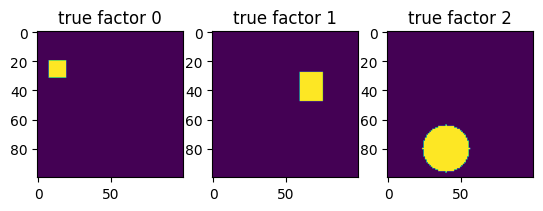

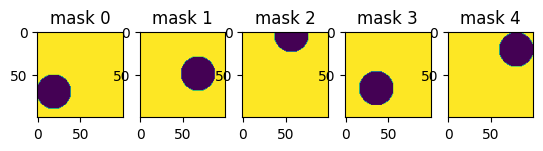

In [24]:
# Plot the factors
fig, axs = plt.subplots(1, num_factors)
for k in range(num_factors):
    axs[k].imshow(true_factors[k])
    axs[k].set_title("true factor {}".format(k))

# Plot the factors
fig, axs = plt.subplots(1, 5)
for m in range(5):
    axs[m].imshow(mask[m])
    axs[m].set_title("mask {}".format(m))

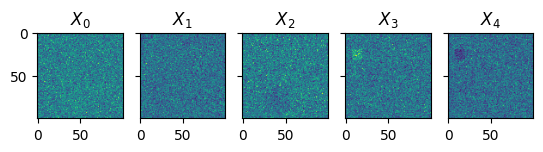

In [25]:
# Plot some of the data
fig, axs = plt.subplots(1, 5, sharey=True)
for m in jnp.arange(5):
    axs[m].imshow(data[m])
    axs[m].set_title(r"$X_{}$".format(m))

### Flatten the data before fitting

In [26]:
flat_data = data.reshape(num_mice, -1)
flat_mask = mask.reshape(num_mice, -1)

## Fit the model!

In [67]:
mean_func = "softplus"
initial_params = None
# sparsity_penalty = 0.2
sparsity_penalty = 1 / loading_scale
elastic_net_frac = 1.0
num_iters = 100
# num_iters = 0
num_coord_ascent_iters = 20

initial_params = seminmf.initialize_random(jr.PRNGKey(1), flat_data, 8, mean_func)
# initial_params = seminmf.initialize_greedy(flat_data, 1, mean_func)

# Fit the model
params, losses, heldout_loglikes = \
    seminmf.fit_poisson_seminmf(flat_data, 
                                initial_params,
                                mask=flat_mask,
                                mean_func=mean_func,
                                sparsity_penalty=sparsity_penalty,
                                elastic_net_frac=elastic_net_frac,
                                num_iters=num_iters,
                                num_coord_ascent_iters=num_coord_ascent_iters,
                                tolerance=1e-5
                                )

  0%|          | 0/100 [00:00<?, ?it/s]

Text(0, 0.5, 'heldout log like')

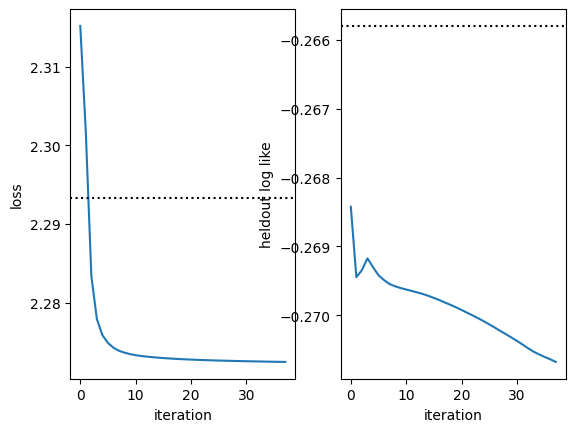

In [68]:
# Plot the losses
fig, axs = plt.subplots(1, 2)
axs[0].plot(losses)
axs[0].axhline(seminmf.compute_loss(flat_data, flat_mask, true_params, mean_func, sparsity_penalty, elastic_net_frac),
            ls=':', color='k', label='loss with true params')
axs[0].set_xlabel("iteration")
axs[0].set_ylabel("loss")

axs[1].plot(heldout_loglikes)
axs[1].axhline(seminmf.heldout_loglike(flat_data, flat_mask, true_params, mean_func),
            ls=':', color='k', label='loss with true params')
axs[1].set_xlabel("iteration")
axs[1].set_ylabel("heldout log like")


In [57]:
from scipy.optimize import linear_sum_assignment
from dataclasses import replace

def permute_parameters(params, true_params):
    def find_permutation(factors, true_factors):
        """
        Find the permutation of the inferred factors so that they best align
        with the true factors

        Returns:
            permutation such that ``jnp.take(perm, factors)`` best aligns with ``true_factors``.
            
        """
        overlap = jnp.einsum('k...,j...->kj', true_factors, factors) 
        _, perm = linear_sum_assignment(-overlap)
        unused = set(range(len(factors))) - set(perm)
        if len(unused) > 0:
            return jnp.concatenate([perm, jnp.array(list(unused))])
        else:
            return perm

    perm = find_permutation(params.factors, true_params.factors)
    perm_factors = jnp.take(params.factors, perm, axis=0)
    perm_loadings = jnp.take(params.loadings, perm, axis=1)
    return replace(params, factors=perm_factors, loadings=perm_loadings)

params = permute_parameters(params, true_params)

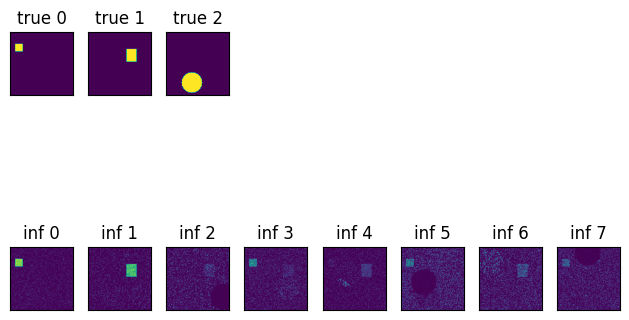

In [58]:
# Plot the factors
fig, axs = plt.subplots(2, params.num_factors)
for k in range(params.num_factors):
    if len(true_factors) > k:
        axs[0, k].imshow(true_factors[k])
        axs[0, k].set_title("true {}".format(k))
    else:
        axs[0, k].set_visible(False)
    
    axs[1, k].imshow(params.factors[k].reshape(height, width))
    axs[1, k].set_title("inf {}".format(k))

    axs[0, k].set_xticks([])
    axs[0, k].set_yticks([])
    axs[1, k].set_xticks([])
    axs[1, k].set_yticks([])

plt.tight_layout()

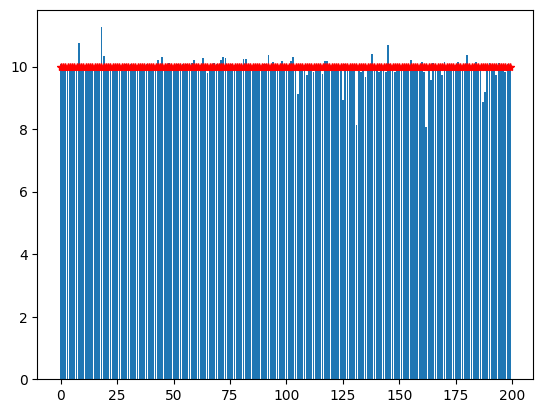

In [59]:
plt.bar(jnp.arange(num_mice), params.row_effects)
plt.plot(jnp.arange(num_mice), true_params.row_effects, ls='none', marker='*', color='r')

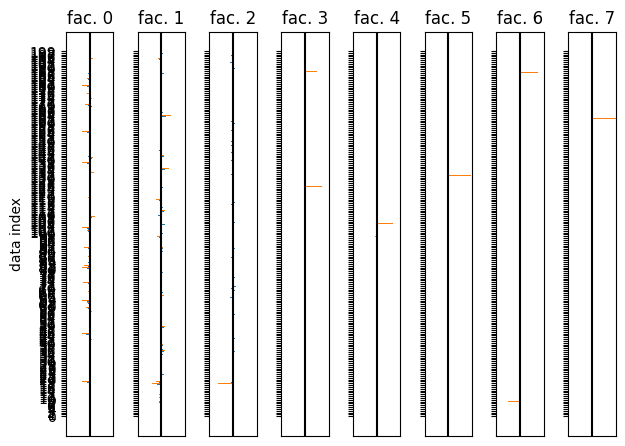

In [60]:
# Plot the loadings
fig, axs = plt.subplots(1, params.num_factors, sharey=True)
xmax = max(abs(true_params.loadings).max(), abs(params.loadings).max())
for k in range(params.num_factors):
    if num_factors > k:
        axs[k].barh(jnp.arange(num_mice), true_loadings[:, k], height=0.5, label='true')
    else:
        axs[k].barh(jnp.arange(num_mice), jnp.zeros(num_mice), height=0.5, label='true')
    axs[k].barh(jnp.arange(num_mice)+.5, params.loadings[:, k], height=0.5, label='inf')
    axs[k].axvline(0, color='k')
    axs[k].set_title("fac. {}".format(k))
    axs[k].set_yticks(jnp.arange(num_mice) + .5)
    axs[k].set_yticklabels(jnp.arange(num_mice))
    # axs[k].set_xlabel("loading")
    axs[k].set_xlim(-xmax, xmax)
    axs[k].set_xticks([])

    
    if k == 0:
        axs[k].set_ylabel("data index")
        
    # if k == num_factors - 1:
    #     axs[k].legend(loc="lower right")

        plt.tight_layout()

<BarContainer object of 8 artists>

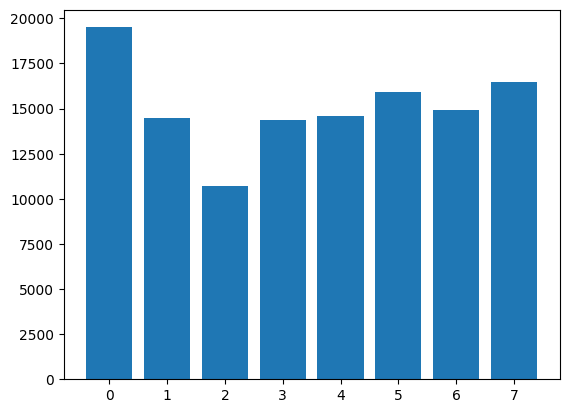

In [61]:
plt.bar(jnp.arange(params.num_factors), jnp.sqrt(jnp.sum(params.loadings ** 2, axis=0)))

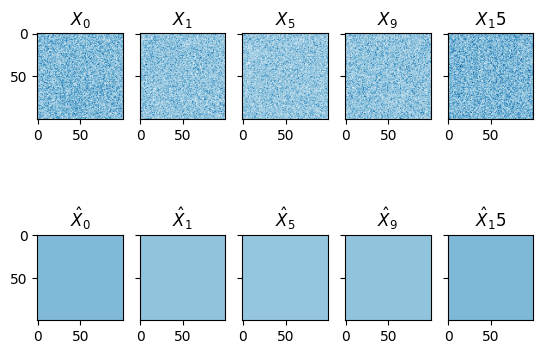

In [62]:
# Plot data and reconstructions
fig, axs = plt.subplots(2, 5, sharey=True)
reconstruction = seminmf.compute_activations(params).reshape(num_mice, height, width)
inds = [0, 1, 5, 9, 15]

for i, m in enumerate(inds):
    vmax = abs(data[m]).max()
    axs[0, i].imshow(data[m], vmin=-vmax, vmax=vmax, cmap="RdBu")
    axs[0, i].set_title(r"$X_{}$".format(m))
    
    axs[1, i].imshow(softplus(reconstruction[m]), vmin=-vmax, vmax=vmax, cmap="RdBu")
    axs[1, i].set_title(r"$\hat{{X}}_{}$".format(m))